# Previsão de renda

## Etapa 1 CRISP - DM: Entendimento do negócio

O objetivo principal deste projeto é desenvolver um modelo preditivo robusto e preciso para a estimativa da renda de novos clientes, utilizando técnicas de inteligência artificial e machine learning.

A partir de um conjunto de dados anonimizados contendo informações cadastrais e transacionais dos clientes, o modelo será capaz de auxiliar na avaliação de risco de crédito e na personalização de ofertas de produtos e serviços.

## Etapa 2 Crisp-DM: Entendimento dos dados

As variáveis disponíveis para essa análise se descrevem na tabela abaixo.

### Dicionário de dados

Cada linha da base de dados corresponde a um cliente, e as colunas são as seguintes:


| Variável                | Descrição                                           | Tipo      |
| ----------------------- |:---------------------------------------------------:| ---------:|
| data_ref                |  data de referência                                 | object    |
| id_cliente              |  código de identificação do cliente                 | int64     |
| sexo                    |  sexo do cliente (M/F)                              | object    |
| posse_de_veiculo        |  se o cliente possui veículo                        | bool      |
| posse_de_imovel         |  se o cliente possui imóvel                         | bool      |
| qtd_filhos              |  quantidade de filhos                               | int64     |
| tipo_renda              |  origem da renda                                    | object    |
| educacao                |  nível de escolaridade                              | object    |
| estado_civil            |  estado civil                                       | object    |
| tipo_residencia         |  tipo de residência                                 | object    |
| idade                   |  idade do cliente                                   | int64     |
| tempo_emprego           |  tempo de emprego                                   | float64   |
| qt_pessoas_residencia   |  quantidade de pessoas que moram na residência      | float64   |
| renda                   |  valor da renda mensal                              | float64   |





A variável "renda" é o alvo desse estudo. 

#### Carregando os pacotes
Carregamos os pacotes a serem utilizados:

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#from ydata_profiling import ProfileReport

import patsy
import statsmodels.api as sm

from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#### Carregando os dados
O comando pd.read_csv é um comando da biblioteca pandas (pd.) e carrega os dados do arquivo csv indicado para um objeto *dataframe* do pandas.

O arquivo csv utilizado foi disponibilizado pela EBAC. 

In [5]:
df = pd.read_csv('./input/previsao_de_renda.csv')

In [6]:
df.head(5)

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis. 

In [13]:
df.isna().sum()

Unnamed: 0                  0
data_ref                    0
id_cliente                  0
sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            2573
qt_pessoas_residencia       0
renda                       0
dtype: int64

In [14]:
df.nunique()

Unnamed: 0               15000
data_ref                    15
id_cliente                9845
sexo                         2
posse_de_veiculo             2
posse_de_imovel              2
qtd_filhos                   8
tipo_renda                   5
educacao                     5
estado_civil                 5
tipo_residencia              6
idade                       47
tempo_emprego             2589
qt_pessoas_residencia        9
renda                     9786
dtype: int64

##### Variáveis Numéricas

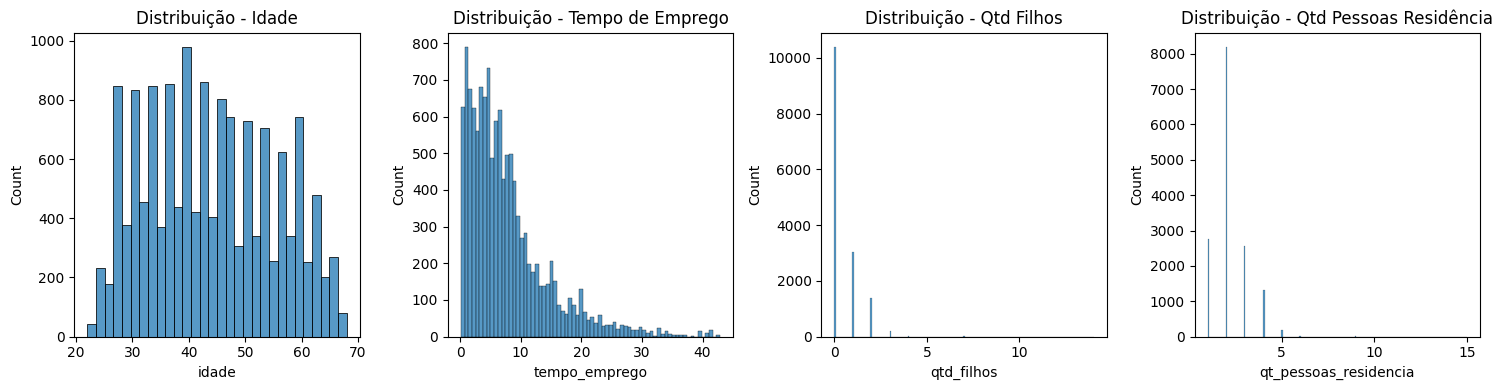

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))

# Idade
sns.histplot(df['idade'], ax=axes[0])
axes[0].set_title('Distribuição - Idade')

# Tempo de Emprego
sns.histplot(df['tempo_emprego'], ax=axes[1])
axes[1].set_title('Distribuição - Tempo de Emprego')

# Quantidade de Filhos
sns.histplot(df['qtd_filhos'], ax=axes[2])
axes[2].set_title('Distribuição - Qtd Filhos')

# Quantidade de pessoas na residência
sns.histplot(df['qt_pessoas_residencia'], ax=axes[3])
axes[3].set_title('Distribuição - Qtd Pessoas Residência')

plt.tight_layout()
plt.show()

##### Variáveis Categóricas

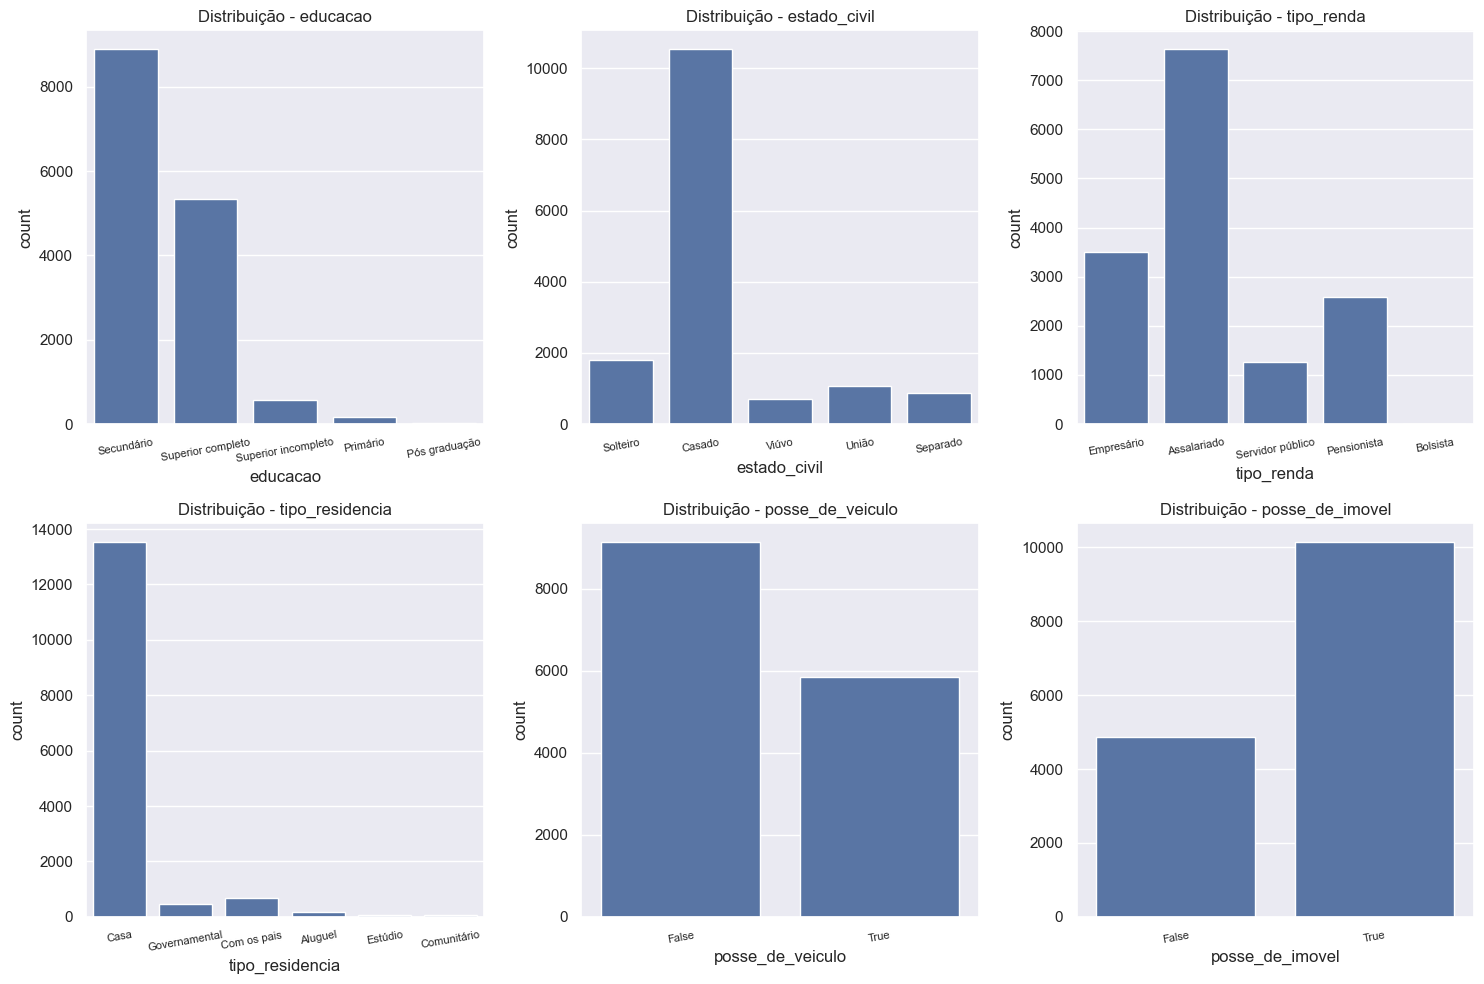

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

categorias = ['educacao', 'estado_civil', 'tipo_renda', 'tipo_residencia', 'posse_de_veiculo', 'posse_de_imovel']

for i, categoria in enumerate(categorias):
    sns.countplot(x=categoria, data=df, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'Distribuição - {categoria}')

for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=10, fontsize=8)
        
plt.tight_layout()
plt.show()

A análise exploratória dos dados apontou que a variável "tempo_emprego" possui 2573 valores faltantes, o que representa 17.2% dos dados, sendo um valor considerável. Por isso será necessário avaliar o impacto da remoção desses dados na estatística. 

A variável "Unnamed: 0" possui somente valores únicos, e não agrega nenhum valor para a análise, então será descartada. 


### Entendimento dos dados - Bivariadas




A análise bivariada dos dados nos permite ter uma visão sobre a relação entre as variáveis, a existência de correlação, e quais variáveis que devemos analisar mais profundamente. 
Vamos criar uma matriz de design com o Patsy, para determinar quais variáveis tem mais influência na renda. Para isso as variáveis categóricas devem ser passadas na fórmula definindo-se como casela de referência a categoria mais frequente. 

In [58]:
for variavel in categorias:
    print(f"Casela de referência para {variavel}:\n{df[variavel].value_counts().idxmax()}\n")

Casela de referência para educacao:
Secundário

Casela de referência para estado_civil:
Casado

Casela de referência para tipo_renda:
Assalariado

Casela de referência para tipo_residencia:
Casa

Casela de referência para posse_de_veiculo:
False

Casela de referência para posse_de_imovel:
True



In [61]:
formula = (
    'renda ~ sexo + idade + C(posse_de_veiculo, Treatment(False)) + posse_de_imovel + '
    'tempo_emprego + qtd_filhos + qt_pessoas_residencia + '
    'C(tipo_renda, Treatment("Assalariado")) + '
    'C(educacao, Treatment("Secundário")) + '
    'C(estado_civil, Treatment("Casado")) + '
    'C(tipo_residencia, Treatment("Casa"))'
)

y, X = patsy.dmatrices(formula, data=df)

reg = sm.OLS(y,X).fit()
print(reg.summary())  

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     178.0
Date:                Mon, 11 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:40:40   Log-Likelihood:            -1.2879e+05
No. Observations:               12427   AIC:                         2.576e+05
Df Residuals:                   12402   BIC:                         2.578e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

Com a análise das variáveis no patsy, usamos o P-value como critério para descartar as variáveis menos significativas. Após a filtragem, as variáveis restantes foram: sexo, idade, tempo_emprego, posse_imovel, educacao(Superior Completo), e tipo_renda(Empresário). Como algumas dessas são apenas uma das categorias da variável, criaremos as dummies na preparação dos dados. 

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Seleção das colunas que serão utilizadas.
 - **limpeza**: Tratamento dos dados faltantes.
 - **construção**: construção de novas variáveis que podem ser úteis.
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Transformação dos dados para formatos adequados à análise. 



Eliminando a coluna "Unnamed: 0":

In [8]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head(5)

,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


Em seguida, para os dados faltantes na variável "tempo_emprego", o tratamento consiste na escolha do destino desses dados, se serão eliminados, ou substituidos por algum valor. Como o tempo de emprego não se aplica a todos os tipos de renda, é possível que essa seja a origem dos dados faltantes. Vamos confirmar isso cruzando os dados dessas colunas:

In [9]:
pd.crosstab(df['tipo_renda'], df['tempo_emprego'].isna())

tempo_emprego,False,True
tipo_renda,,
Assalariado,7633,0
Bolsista,9,0
Empresário,3508,0
Pensionista,9,2573
Servidor público,1268,0


A tabela acima confirma que os dados faltantes da variável "tempo_emprego" correspondem ao "tipo_renda" = "Pensionista", o que faz sentido prático. A variável tempo_emprego é um dos fatores mais importantes nessa análise, enquanto que o tipo_renda "Pensionista" não foi uma das variáveis selecionadas na análise bivariada. Portanto podemos eliminar esses dados sem impacto nos resultados. 

In [10]:
df.drop(df[df['tipo_renda'] == 'Pensionista'].index, inplace=True)

Também é necessário criar as dummies para as variáveis 'educacao' e 'tipo_renda', para que possamos trabalhar com as categorias selecionadas na análise do P-value:

In [81]:
df_dummies = pd.get_dummies(df, columns=['sexo', 'educacao', 'tipo_renda'])
df_dummies.columns


Index(['Unnamed: 0', 'data_ref', 'id_cliente', 'posse_de_veiculo',
       'posse_de_imovel', 'qtd_filhos', 'estado_civil', 'tipo_residencia',
       'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'sexo_F',
       'sexo_M', 'educacao_Primário', 'educacao_Pós graduação',
       'educacao_Secundário', 'educacao_Superior completo',
       'educacao_Superior incompleto', 'tipo_renda_Assalariado',
       'tipo_renda_Bolsista', 'tipo_renda_Empresário',
       'tipo_renda_Pensionista', 'tipo_renda_Servidor público'],
      dtype='object')

In [82]:
selected = ['sexo_M', 'idade', 'tempo_emprego', 'posse_de_imovel', 'educacao_Superior completo', 'tipo_renda_Empresário']
#Essas são as variáveis selecionadas para a modelagem.

## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


Para esse conjunto de dados utilizaremos um modelo de árvore de regressão a partir das variáveis selecionadas na regressão linear. 


### Rodando o modelo


In [13]:
X = df_dummies[selected]
y = df_dummies['renda']

Realizaremos uma pré-poda para determinar qual a profundidade ótima para a árvore. Isso é feito através de um loop que calcula o R² para diferentes árvores geradas com diferentes random_seeds, e também diferentes conjuntos de treino/teste determinados por diferentes random_seeds. No fim a média de cada profundidade é calculada e exibida no gráfico. Para manter o cálculo em um tempo de execução aceitável o loop será feito em 20 random_seeds e profundidade da árvore variando até 20. (Os resultados foram os mesmos para valores maiores, porém o tempo de execução fica muito longo). 

In [14]:
# Defina a faixa de profundidades
depths = np.arange(1, 21)

# Lista para armazenar os resultados finais
r2_means = []

# Loop sobre diferentes profundidades
for depth in depths:
    r2_scores_for_depth = []
    # Loop sobre diferentes random_seed:
    for seed_tree in range(21):
        for seed_split in range(21):             
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_split)
            loop_tree = DecisionTreeRegressor(max_depth=depth, random_state=seed_tree)
            r2_scores = cross_val_score(loop_tree, X_train, y_train, cv=5, scoring='r2')
            r2_scores_for_depth.extend(r2_scores)
    # Calculando a média dos R² para a profundidade da vez
    r2_mean_for_depth = np.mean(r2_scores_for_depth)
    r2_means.append(r2_mean_for_depth)

print("Lista de R² médio para cada profundidade:")
print(r2_means)

Lista de R² médio para cada profundidade:
[0.09080290589499655, 0.24847249170387906, 0.34678095928557273, 0.3834523307848378, 0.3720549348866835, 0.3607219635537989, 0.3547552350963504, 0.3492323995325815, 0.33921516378274313, 0.3333591414262317, 0.3290669839894767, 0.3206306900660462, 0.31761731442910873, 0.3129653276347713, 0.3104254716917361, 0.307367753564203, 0.30648613794466983, 0.3046839295610145, 0.3037354098198547, 0.30444025826249554]


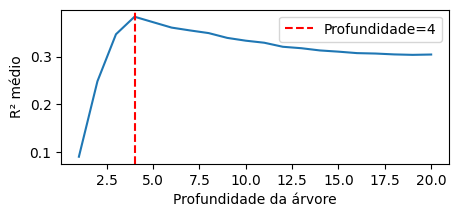

In [24]:
plt.figure(figsize=(5,2))
plt.plot(depths, r2_means)
max_value = max(r2_means)
max_index = r2_means.index(max_value)
plt.axvline(x=depths[max_index], color='red', linestyle='--', label=f'Profundidade={depths[max_index]}')
plt.xlabel("Profundidade da árvore")
plt.ylabel("R² médio")
plt.legend()

O gráfico mostra os valores médios de R² para cada profundidade, considerando todos valores possíveis de random_seed tanto para a divisão do conjunto de dados quanto para a construção da árvore de regressão. Pelo gráfico vemos que o valor ótimo para a profundidade dessa árvore é de 4. 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)


In [30]:
regtree = DecisionTreeRegressor(max_depth=4, random_state=42)
regtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

In [31]:
y_pred = regtree.predict(X_test)
r2 = regtree.score(X_test, y_test)
print("R² da árvore:", r2.round(3))

R² da árvore: 0.419


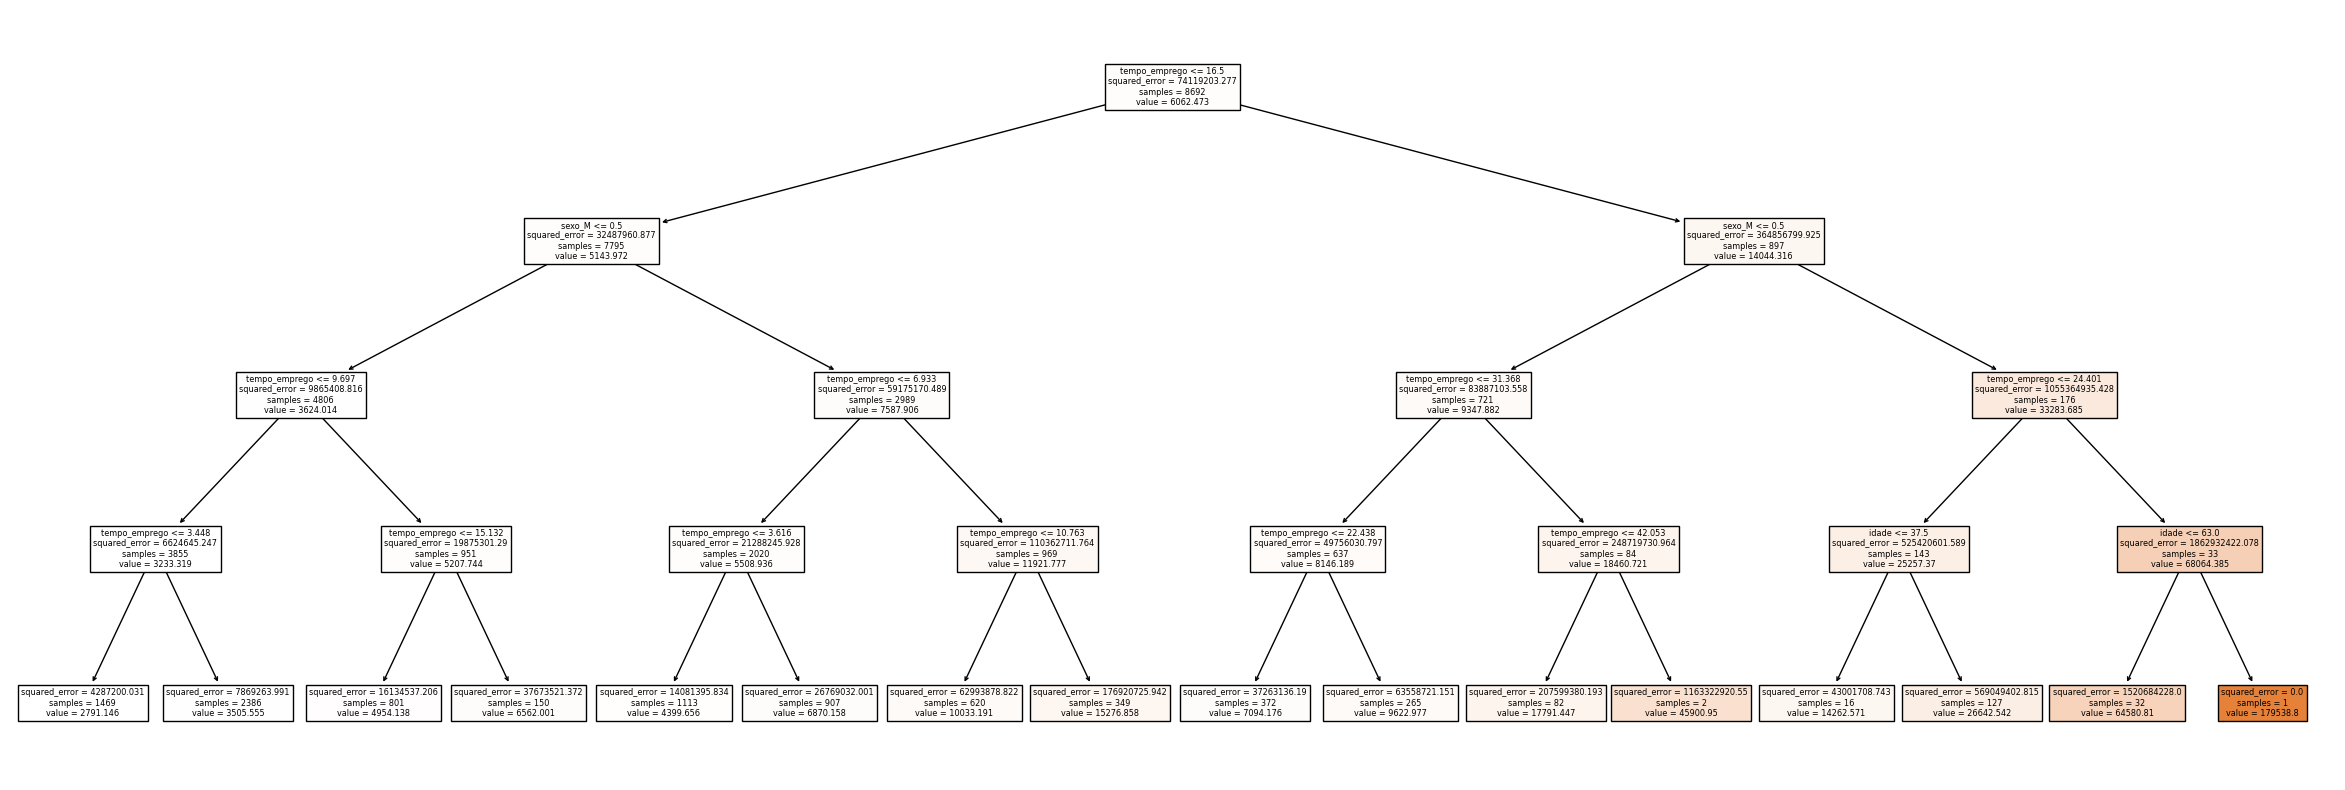

In [36]:
%matplotlib inline
plt.figure(figsize=(30,10))
plot_tree(regtree, feature_names=list(X.columns), filled=True)
plt.savefig("arvore_renda.png")
plt.show()


## Etapa 5 Crisp-DM: Avaliação dos resultados


Vemos na árvore de regressão que as variáveis tempo_emprego e sexo são as mais determinantes na construção do modelo. A idade se mostra como sendo determinante para as rendas de maior valor (tom laranja mais escuro).

Para tempo_emprego inferior a 16, as rendas são em geral menores que as rendas referentes ao tempo de emprego superior a 16, independente da idade, e as rendas das mulheres são menores que as rendas dos homens, sendo a maior renda prevista para mulheres 6562, enquanto para os homens 15276. Ainda inferior a 16 anos, as quebras no tempo de emprego que definem a maior renda prevista ocorrem em um valor mais alto para as mulheres (15) do que para os homens (10), indicando que para a mulher são necessários mais anos de emprego para atingir o mesmo salário do que os homens, além de que nunca se atinge o salário máximo masculino. 

Para o tempo_emprego superior a 16, as rendas são as maiores, e existe uma grande diferença nos valores previstos de renda para as mulheres e os homens, seguindo a mesma tendência do grupo <16, mas com uma grande diferença no valor da renda, onde os homens com mais tempo de emprego , em particular com mais de 24 anos de emprego possuem as maiores rendas presentes. O maior valor previsto de renda ocorre para homens acima de 63 anos, com mais de 24 anos de emprego. 

Para mulheres com mais de 42 anos de emprego os valores de renda são consideravelmente maiores que todas outras exceto homens com mais de 24 anos de emprego. 

Algumas variáveis que foram selecionadas acabaram não fazendo parte da árvore podada: 'posse_de_imovel', 'educacao_Superior completo', 'tipo_renda_Empresário'. Isso significa que essas variáveis influenciam em um grau bem menor do que as outras que estão presentes na árvore. Elas são determinantes apenas depois que as outras já fizeram sua contribuição, ou seja, de forma secundária. 

De forma geral espera-se que a renda seja proporcional ao tempo de emprego, idade, e também se espera que a renda seja maior para clientes do sexo masculino, por exemplo para um homem e uma mulher com mesma idade e mesmo tempo de emprego, ao invés de se esperar a mesma renda, a probabilidade é que a renda do homem será consideravelmente maior. 

## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.

A escolha do modelo de árvore de regressão foi feita considerando que o tipo dos dados a serem trabalhados possuem muita variabilidade e seriam melhor modelados na forma que a árvore opera. A regressão linear também poderia ser aplicada mas isso implica que existe uma relação muito mais estrita entre as variáveis e o alvo renda, o que não acontece na realidade. Na realidade os dados são bem mais distribuídos do que uma simples regressão poderia explicar. Já com a árvore apesar de ainda não ser o melhor ajuste, existe uma maior adaptação às diversas relações que existem entre as variáveis e a renda do cliente. A implantação deve ser considerada com cautela pois o R² indica que o modelo explica apenas em torno de 41,9% dos dados. O modelo também mostra claramente que existe um problema social relacionado com a disparidade salarial entre os gêneros. É importante que isso seja exposto ao invés de ser ocultado, pois é algo que deve ser corrigido estruturalmente para que tenhamos uma sociedade mais justa. 